# Heuristicas

In [2]:
import utils
import pandas as pd
import seaborn as sns

DATA = "../data/sim.dat"
POWERS = "../data/sim_powers.tsv"

In [4]:
def read_powers() -> pd.DataFrame:
    return pd.read_csv(
        POWERS,
        sep=' ',
        header=None,
        names=["team", "power"],
    )

def read_sim_ranking(method: str):
    powers = read_powers()
    ranking = utils.read_ranking(DATA+method+utils.OUT)
    ranking["power"] = (ranking.index + 1).map(powers.set_index("team")["power"])
    ranking["team"] = (ranking.index+1)
    return ranking

In [ ]:
utils.run(DATA, utils.METHOD_CMM)
utils.run(DATA, utils.METHOD_WP)

In [ ]:
read_sim_ranking(utils.METHOD_CMM).sort_values("rating", ascending=False)

In [ ]:
utils.analyze_data(DATA)

0
100
200
300
400


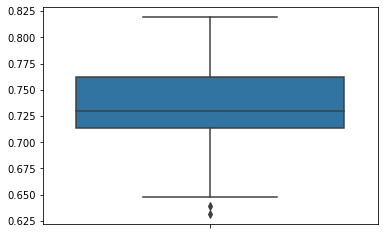

In [13]:
# iterar e imprimir boxplot

import simulator
import time

TEAM = 20
ITER = 500
ratings = []

for i in range(ITER):
    if i % 100 == 0: print(i)
    simulator.simulate(team_count=20)
    utils.run(DATA, utils.METHOD_CMM)
    ranking = read_sim_ranking(utils.METHOD_CMM).sort_values("rating", ascending=False)
    rating = ranking.set_index("team").at[TEAM, "rating"]
    ratings.append(rating)

sns.boxplot(ratings, orient="v")

In [ ]:
def heuristic(games: List[simulator.Game]) -> List[simulator.Game]:
    # calculas cmm
    # run()
    # modificas los partididos segun tu heuristica
    # run()
    # ves el ranking
    